In [152]:
# Source: Alexandru Tifrea and Fanny Yang, 2021.

# Python Notebook Commands
%reload_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import HTML
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from copy import deepcopy
import numpy as np
import time

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from scipy.optimize import line_search

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

# TODO: use plotly instead of matplotlib.
import matplotlib.pyplot as plt
import autograd.numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation, rc

# TODO: use jax instead of autograd.
from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize, OptimizeResult, fmin
from collections import defaultdict
from itertools import zip_longest, product
from functools import partial

import ipywidgets
from ipywidgets import interact, interactive, interact_manual

from optimization_utils import TrajectoryAnimation, TrajectoryAnimation3D

# Change these values if the images don't fit for your screen.
figure_width=12
figure_height=12

colors = ["purple", "blue", "black", "green", "cyan", "orange"]
markers = ["o", "v", "+", "^", "s"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Convergence of gradient descent to the max-margin solution

In [2]:
def load_toy_data(seed=None):
    def gen_one_class(mean, Sigma_diag=None, dim=2, num_points=20):
      mean = np.array(mean)
      x = np.random.normal(size=(num_points, dim))
      x = mean + x @ np.diag(np.sqrt(Sigma_diag))
      return x

    np.random.seed(seed)
    num_points = 200

    mean = np.array([0, 0.5])
    Sigma_diag = np.array([1, 0.01])

    mean_offset = 0.
    x = np.concatenate((
        gen_one_class(mean=mean_offset - mean, Sigma_diag=Sigma_diag, dim=2, num_points=num_points // 2),
        gen_one_class(mean=mean_offset + mean, Sigma_diag=Sigma_diag, dim=2, num_points=num_points // 2)),
      axis=0)
    y = np.concatenate((np.zeros(num_points // 2), np.ones(num_points // 2))).reshape(-1)
    idx = np.random.permutation(num_points)
    x, y = x[idx], y[idx]
    x_train, y_train = x[:num_points // 2], y[:num_points // 2]
    x_test, y_test = x[num_points // 2:], y[num_points // 2:]
    return x_train, y_train, x_test, y_test

In [3]:
def show_gd_animation():  
  # Train logistic regression using gradient descent.
  x_train, y_train, x_test, y_test = load_toy_data(seed=2)
  clf = SGDClassifier(max_iter=1, fit_intercept=True, tol=None, loss="log", 
                      learning_rate="constant", eta0=0.001, warm_start=True)
  num_epochs = 100
  Ws, bs = [], []
  for i in range(num_epochs):
    if i == 0:
      coef_init, intercept_init = [0.1, 0.1], 0.
      Ws.append(coef_init)
      bs.append([intercept_init])
    else:
      coef_init, intercept_init = None, None
    clf.fit(x_train, y_train, coef_init=coef_init, intercept_init=intercept_init)
    Ws.append(clf.coef_[0])
    bs.append(clf.intercept_)
  
  # Get maximum margin classifier.
  svc = SVC(C=1000, kernel='linear')
  svc.fit(x_train, y_train)

  def plot_decision_boundary(W, b, name="", color=None):
    x1 = np.linspace(-10, 10, 100)
    x2 = (-b[0] - W[0] * x1) / W[1]
    return go.Scatter(x=x1, y=x2, line=dict(color=color, width=3), 
                      mode="lines", name=name)

  x0, x1 = x_train[y_train == 0], x_train[y_train == 1]
  fig = go.Figure(
    data=[
      plot_decision_boundary(Ws[0], bs[0], "Classifier trained with GD", color="orange"),
      plot_decision_boundary(svc.coef_[0], svc.intercept_, "Max. margin classifier", color="black"),
      go.Scatter(x=x0[:, 0], y=x0[:, 1], mode="markers", 
                 marker_symbol="circle", marker_color="red", marker_size=9,
                 name="Samples from class 0"),
      go.Scatter(x=x1[:, 0], y=x1[:, 1], mode="markers", 
                 marker_symbol="cross", marker_color="blue", marker_size=9,
                 name="Samples from class 1"),
    ],
    frames=[go.Frame(data=[plot_decision_boundary(Ws[epoch], bs[epoch], "Gradient descent classifier", color="orange")])
            for epoch in range(num_epochs)])

  fig.update_layout(width=850, height=700,
                    xaxis_tickvals = np.arange(-2, 2.1, 0.5),
                    yaxis_tickvals = np.arange(-2, 2.1, 0.5),
                    xaxis_range=[-2, 2],
                    yaxis_range=[-2, 2],
                    updatemenus=[dict(
                      type="buttons",
                      buttons=[
                        dict(label="Play", method="animate", 
                             args=[None, 
                                   {
                                     "frame": {"duration": 2500, "redraw": False},
                                     "fromcurrent": True, 
                                     "transition": {"duration": 2500, "easing": "linear"}
                                   }]),
                        dict(label="Pause", method="animate", 
                             args=[[None], 
                                   {
                                     "frame": {"duration": 0, "redraw": False},
                                     "mode": "immediate",
                                     "transition": {"duration": 0}
                                   }]),
                      ])])
  fig.show()

interact_manual(show_gd_animation);

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

# Impact of some hyperparameters on the optimization path

In [167]:
x1min, x1max, x1step = -4., 6.5, .2
x2min, x2max, x2step = -4., 6.5, .2

def init_optimization_problem(l2_coef=0., condition_number=1.):
  d = 2
  n = 100
  noise_sigma = 0.
  np.random.seed(42)
  
  sqrt_Sigma = np.diag([condition_number * 1., 1.])
  X = np.random.normal(size=(n, d)) @ sqrt_Sigma
  beta_star = np.array([1., 3.])
  y = (X @ beta_star).reshape(n, 1) + np.random.normal(size=(n, 1)) * noise_sigma

  f = lambda x: (((X[:, 0] * x[0].reshape((-1, 1)) + X[:, 1] * x[1].reshape((-1, 1))).T - y)**2).mean(axis=0).reshape(x[0].shape) + l2_coef * (x[0]**2 + x[1]**2)

  global_minimum = fmin(func=f, x0=[0, 0], full_output=False, disp=False)

  # Get function values for a grid.
  x1, x2 = np.meshgrid(np.arange(x1min, x1max + x1step, x1step), np.arange(x2min, x2max + x2step, x2step))
  z = f(np.array(list(zip(x1.reshape(-1), x2.reshape(-1)))).T).reshape(x1.shape)
  return {
    "f": f,
    "x1": x1,
    "x2": x2,
    "z": z,
    "global_minimum": global_minimum,
  }

### Loss landscape

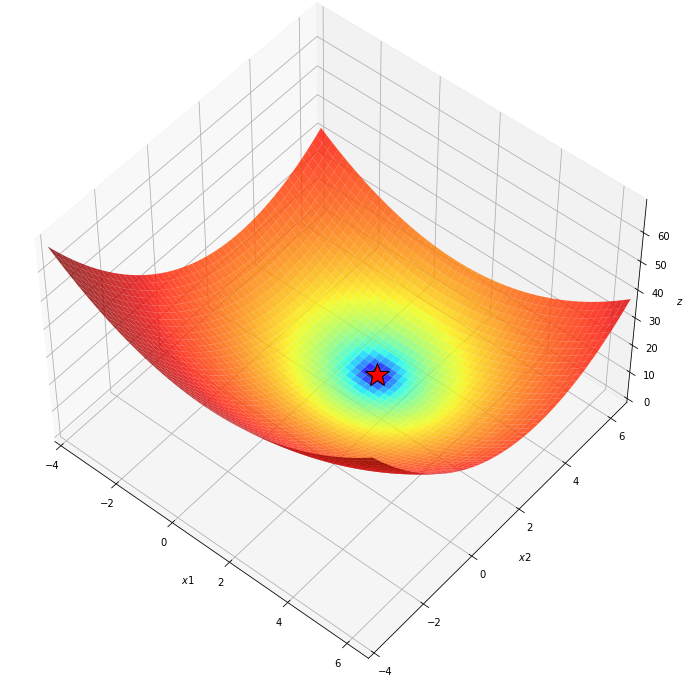

In [169]:
opt_pb = init_optimization_problem()
x1, x2, z = opt_pb["x1"], opt_pb["x2"], opt_pb["z"]
f, global_minimum = opt_pb["f"], opt_pb["global_minimum"]

fig = plt.figure(figsize=(figure_width, figure_height))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x1, x2, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot([global_minimum[0]], [global_minimum[1]], [f(global_minimum)], 'r*', markersize=25, 
        markeredgecolor="black", color="red", zorder=10)

ax.set_xlabel('$x1$')
ax.set_ylabel('$x2$')
ax.set_zlabel('$z$')

ax.set_xlim((x1min, x1max))
ax.set_ylim((x2min, x2max))

plt.show()

### Gradient descent optimization path

In the following plots we show how the optimization path changes with the learning rate, the condition number of the data matrix or the ridge coefficient.

In [170]:
def get_optimization_path(opt_pb, methods):
  x0 = np.array([3., -3.5])
  f = opt_pb["f"]
  func = value_and_grad(lambda args: f(args))
  
  minimize_ = partial(minimize, fun=func, x0=x0, jac=True, bounds=[(x1min, x1max), (x2min, x2max)], tol=1e-20)
  
  def make_minimize_callback(path=[]):
    def minimize_callback(xk):
      path.append(np.copy(xk))
    return minimize_callback

  paths_ = defaultdict(list)
  update_function = {}
  for method in methods:
    if "GD" in method:
      lr = method.rsplit("=", 1)[-1]
      update_function[method] = partial(gradient_descent, learning_rate=lr)
    else:
      update_function[method] = method

  results = {method: minimize_(method=update_function[method], callback=make_minimize_callback(paths_[method])) for method in methods}

  paths = [np.array(paths_[method]).T for method in methods]
  zpaths = [f(path) for path in paths]
  return paths, zpaths


def gradient_descent(func, x0, jac, args=(), learning_rate=0.1, startiter=0,
                     maxiter=20, callback=None, **kwargs):
  x = x0
  velocity = np.zeros_like(x)
  
  if learning_rate != "backtracking":
    lr = float(learning_rate)
    get_best_lr = None
  else:
    get_best_lr = partial(line_search, f=f, myfprime=jac, amax=0.5, maxiter=100000)
  
  for i in range(startiter, startiter + maxiter):
    g = jac(x)
    if get_best_lr is not None:
      lr, fc, gc, _, _, slope = get_best_lr(xk=x, pk=-g)
    if callback and callback(x):
        break
    x = x - lr * g

  i += 1
  return OptimizeResult(x=x, fun=func(x), jac=g, nit=i, nfev=i, success=True)


def show_animation(paths, zpaths, methods, opt_pb, plot_type="2D"):
  x1, x2, z = opt_pb["x1"], opt_pb["x2"], opt_pb["z"]
  f, global_minimum = opt_pb["f"], opt_pb["global_minimum"]
  
  fig, ax = plt.subplots(figsize=(figure_width, figure_height))
  interval = 300

  if plot_type == "2D":
    ax.contour(x1, x2, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
    ax.plot([global_minimum[0]], [global_minimum[1]], 'r*', markersize=30, markeredgecolor="black", color="red", zorder=10)
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_xlim((x1min, x1max))
    ax.set_ylim((x2min, x2max))
    
    anim = TrajectoryAnimation(*paths, colors=colors, markers=markers,
                               interval=interval, labels=methods, ax=ax)
  elif plot_type == "3D":
    ax = plt.axes(projection='3d', elev=50, azim=-50)
    ax.plot_surface(x1, x2, z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.8, cmap=plt.cm.jet)
    ax.plot([global_minimum[0]], [global_minimum[1]], f(global_minimum), 'r*', markersize=30,
            markeredgecolor="black", color="red", zorder=10)
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.set_xlim((x1min, x1max))
    ax.set_ylim((x2min, x2max))
    
    anim = TrajectoryAnimation3D(*paths, zpaths=zpaths, colors=colors, markers=markers,
                                 interval=interval, labels=methods, ax=ax)
  else:
    raise RuntimeError(f"Unrecognized plot type {plot_type}. Should be one of '2D' or '3D'")

  plt.close()
  ax.legend(loc='upper left')
  return anim


def show_animation_wrapper(plot_type="2D", learning_rate=None, l2_coef=0., condition_number=1.):
  opt_pb = init_optimization_problem(l2_coef=l2_coef, condition_number=condition_number)
  
  methods = []
  if learning_rate is None:
    lr = 0.1 / (1 + l2_coef)
    methods.append(f"GD lr={lr:.3f}")
  if learning_rate in ["small", "show all options"]:
    lr = 0.01
    methods.append(f"GD lr={lr:.3f}")
  if learning_rate in ["moderate", "show all options"]:
    lr = 0.1
    methods.append(f"GD lr={lr:.3f}")
  if learning_rate in ["large", "show all options"]:
    lr = 0.9
    methods.append(f"GD lr={lr:.3f}")
  
  paths, zpaths = get_optimization_path(opt_pb=opt_pb, methods=methods)
  anim = show_animation(paths=paths, zpaths=zpaths, methods=methods, opt_pb=opt_pb, plot_type=plot_type)
  display(HTML(anim.to_jshtml()))

In [171]:
plot_type = ipywidgets.Dropdown(options=["2D", "3D"],
                                value="2D",
                                description='Plot type:',
                                disabled=False,
                                style={'description_width': 'initial'},
                                continuous_update=True)
learning_rate = ipywidgets.Dropdown(options=["small", "moderate", "large", "show all options"],
                                    value="show all options",
                                    description='Learning rate:',
                                    disabled=False,
                                    style={'description_width': 'initial'},
                                    continuous_update=True)
l2_coef = ipywidgets.FloatSlider(min=0, max=10, step=1., 
                                 value=0.,
                                 readout_format='.1f', 
                                 description='Ridge coefficient:', 
                                 style={'description_width': 'initial'},
                                 continuous_update=False)
condition_number = ipywidgets.FloatSlider(min=1, max=5, step=1., 
                                          value=1.,
                                          readout_format='.1f', 
                                          description='Condition number:', 
                                          style={'description_width': 'initial'},
                                          continuous_update=False)

interact_manual(show_animation_wrapper, plot_type=plot_type, learning_rate=learning_rate, l2_coef=l2_coef, condition_number=condition_number);

interactive(children=(Dropdown(description='Plot type:', options=('2D', '3D'), style=DescriptionStyle(descript…